## Simple training

In [100]:
import sys
sys.path.append("../src")

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool, SAGEConv

%load_ext autoreload
%autoreload 2

from data import *
from loader import *
from model import *

import matplotlib.pyplot as plt
import pickle
import random
from scipy.stats import binned_statistic, median_abs_deviation
device = "cuda"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def train(dataloader, model, optimizer, device="cuda"):

    model.train()

    loss_total = 0
    for data in dataloader:
        data.to(device)       
        
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    return loss_total / len(dataloader)

def validate(dataloader, model, device="cuda"):
    model.eval()

    uncertainties = []
    loss_total = 0

    y_preds = []
    y_trues = []

    for data in dataloader:
        data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            loss = F.mse_loss(y_pred, data.y)

            loss_total += loss.item()
            y_preds += list(y_pred.detach().cpu().numpy())
            y_trues += list(data.y.detach().cpu().numpy())

    y_preds = np.array(y_preds)
    y_trues = np.array(y_trues)

    return (
        loss_total / len(dataloader),
        y_preds,
        y_trues,
    )

## make data

In [2]:
if not os.path.exists("merger_trees.pkl"):
    subhalos = prepare_subhalos()
    trees = load_trees()

    merger_trees = make_merger_tree_graphs(trees, subhalos)

    with open('merger_trees.pkl', 'wb') as f:
        pickle.dump(merger_trees, f)

In [3]:
with open("merger_trees.pkl", "rb") as f:
    trees = pickle.load(f)

print(len(trees))

91345


## load and look at data

Text(0, 0.5, 'Frequency')

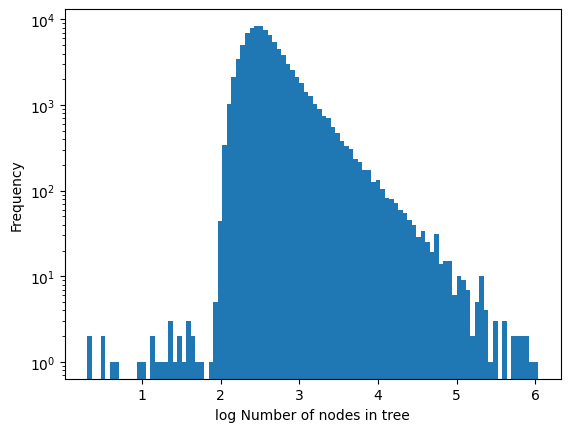

In [8]:
n_nodes = [d.x.size(0) for d in trees]
plt.hist(np.log10(n_nodes), log=True, bins=100)
plt.xlabel("log Number of nodes in tree")
plt.ylabel("Frequency")

In [11]:
# examine trees with > 10^5 nodes
tree_stats = pd.DataFrame({
    "n_nodes": n_nodes,
    "stellar_mass": [d.y.item() for d in trees],
    "peak_halo_mass": [d.x[:, 0].max().item() for d in trees],
    "peak_vmax": [d.x[:, 1].max().item() for d in trees],
})

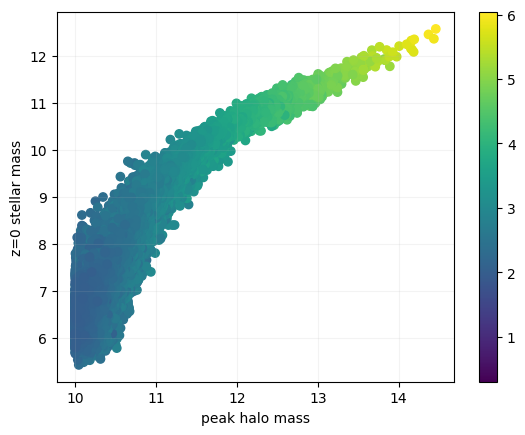

In [10]:
plt.scatter(
    tree_stats.peak_halo_mass,
    tree_stats.stellar_mass,
    c=tree_stats.n_nodes.apply(np.log10)
)

plt.ylabel("z=0 stellar mass")
plt.xlabel("peak halo mass")

plt.colorbar()
plt.grid(alpha=0.15)

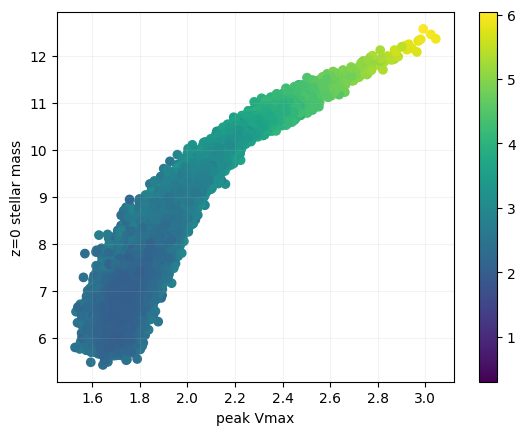

In [12]:
plt.scatter(
    tree_stats.peak_vmax,
    tree_stats.stellar_mass,
    c=tree_stats.n_nodes.apply(np.log10)
)

plt.ylabel("z=0 stellar mass")
plt.xlabel("peak Vmax")

plt.colorbar()
plt.grid(alpha=0.15)

In [13]:
trees[999]

Data(x=[309, 4], edge_index=[2, 308], y=[1])

## Set up model

In [14]:
class SAGEGraphConvNet(torch.nn.Module):
    """A simple GNN built using SAGEConv layers.

    Makes full graph-level predictions (i.e. one for each merger tree)
    """
    def __init__(self, n_in=4, n_hidden=16, n_out=1, aggr="max"):
        super(SAGEGraphConvNet, self).__init__()
        self.conv1 = SAGEConv(n_in, n_hidden, aggr=aggr)
        self.conv2 = SAGEConv(n_hidden, n_hidden, aggr=aggr)
        self.mlp = nn.Sequential(
            nn.Linear(n_in + 2 * n_hidden, n_hidden, bias=True),
            nn.SiLU(),
            nn.LayerNorm(n_hidden),
            nn.Linear(n_hidden, n_hidden, bias=True)
        )
        self.readout = nn.Linear(2 * n_hidden, n_out, bias=True)

    def forward(self, data):
        x0, edge_index = data.x, data.edge_index

        x1 = self.conv1(x0, edge_index)
        x2 = self.conv2(F.silu(x1), edge_index)
        out = self.mlp(torch.cat([F.silu(x2), F.silu(x1), x0], dim=-1))

        out = torch.cat([
            global_mean_pool(out, data.batch),
            global_max_pool(out, data.batch), 
            # global_add_pool(out, data.batch)
        ], axis=1)
        # out = global_mean_pool(out, data.batch)
        
        return self.readout(out)[:, 0]

In [15]:
model = SAGEGraphConvNet().to(device)
model

SAGEGraphConvNet(
  (conv1): SAGEConv(4, 16, aggr=max)
  (conv2): SAGEConv(16, 16, aggr=max)
  (mlp): Sequential(
    (0): Linear(in_features=36, out_features=16, bias=True)
    (1): SiLU()
    (2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
  )
  (readout): Linear(in_features=32, out_features=1, bias=True)
)

In [5]:
random.shuffle(trees)

In [18]:
trees[999]

Data(x=[373, 4], edge_index=[2, 372], y=[1])

In [19]:
model(trees[999].to(device))

tensor([0.1871], device='cuda:0', grad_fn=<SelectBackward0>)

In [20]:

train_loader = DataLoader(trees[:88888], batch_size=32, shuffle=True)
valid_loader = DataLoader(trees[88888:], batch_size=32, shuffle=False)

In [21]:
xb = next(iter(train_loader))
xb.to(device)
y_pred = model(xb)
y_pred

tensor([0.1898, 0.1656, 0.1734, 0.1727, 0.1831, 0.1642, 0.1892, 0.1483, 0.1819,
        0.1798, 0.1718, 0.1840, 0.1884, 0.1858, 0.1700, 0.1725, 0.1788, 0.1498,
        0.1824, 0.1965, 0.1818, 0.1792, 0.1792, 0.1517, 0.1823, 0.1862, 0.1557,
        0.1768, 0.1905, 0.1730, 0.1826, 0.1890], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [22]:
xb.y

tensor([7.8139, 7.5383, 8.9748, 9.7337, 7.6804, 9.1110, 7.4152, 6.2779, 7.6022,
        8.1969, 8.8560, 6.9405, 7.9707, 7.5003, 8.4530, 9.5437, 6.4664, 8.3870,
        6.5699, 6.4048, 6.3936, 8.6821, 7.6406, 6.3050, 8.2928, 7.5929, 6.4196,
        7.6439, 7.0280, 8.1559, 7.0649, 7.2408], device='cuda:0')

In [23]:
F.mse_loss(y_pred, xb.y)

tensor(57.2703, device='cuda:0', grad_fn=<MseLossBackward0>)

## Reload everything cleanly

In [25]:
with open("merger_trees.pkl", "rb") as f:
    trees = pickle.load(f)

random.shuffle(trees)

batch_size = 128

train_loader = DataLoader(trees[:88888], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(trees[88888:], batch_size=batch_size, shuffle=False)

In [26]:
model = SAGEGraphConvNet(n_hidden=32, aggr="max")
model.to(device)

SAGEGraphConvNet(
  (conv1): SAGEConv(4, 32, aggr=max)
  (conv2): SAGEConv(32, 32, aggr=max)
  (mlp): Sequential(
    (0): Linear(in_features=68, out_features=32, bias=True)
    (1): SiLU()
    (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (readout): Linear(in_features=64, out_features=1, bias=True)
)

In [27]:
train_losses = []
valid_losses = []

n_epochs = 100

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

print(f"Epoch    Train loss   Valid Loss      RSME ")
for epoch in range(n_epochs):

    train_loss = train(train_loader, model, optimizer, device=device)
    valid_loss, p, y  = validate(valid_loader, model, device=device)

    print(f" {epoch + 1: >4d}    {train_loss: >9.5f}    {valid_loss: >9.5f}    {np.sqrt(np.mean((p - y.flatten())**2)): >10.6f}")
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

Epoch    Train loss   Valid Loss      RSME 
    1      1.61351      0.19883      0.443508
    2      0.18671      0.16912      0.409630
    3      0.16907      0.16510      0.404868
    4      0.15872      0.15864      0.396567
    5      0.15194      0.15172      0.389141
    6      0.14614      0.14370      0.378038
    7      0.14151      0.13760      0.369288
    8      0.13698      0.12675      0.354355
    9      0.13320      0.14362      0.375556
   10      0.12941      0.12025      0.344636
   11      0.12859      0.12248      0.348950
   12      0.12542      0.13262      0.361643
   13      0.12379      0.11873      0.344441
   14      0.12373      0.11698      0.341031
   15      0.12173      0.11374      0.336062
   16      0.11944      0.11270      0.335611
   17      0.11867      0.10930      0.330763
   18      0.11877      0.11259      0.334193
   19      0.11774      0.12225      0.347980
   20      0.11606      0.10712      0.326898
   21      0.11605      0.11052     

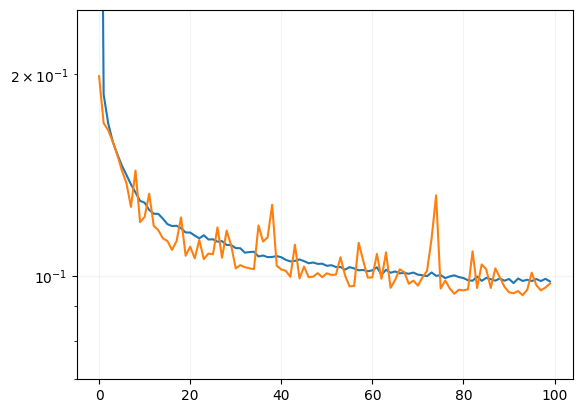

In [28]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.ylim(0.07, 0.25)
plt.yscale("log");
plt.grid(alpha=0.15)

In [29]:
valid_loss, p, y  = validate(valid_loader, model, device=device)

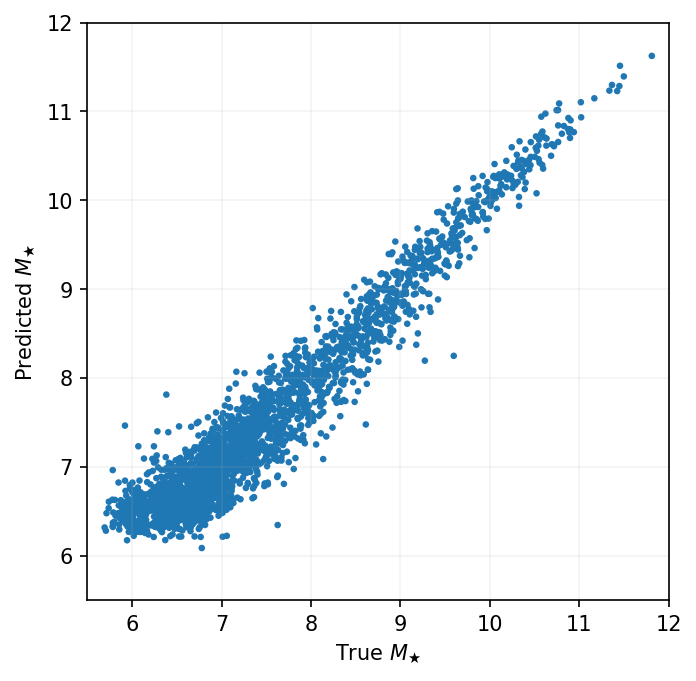

In [30]:
plt.figure(figsize=(5,5), dpi=150)
plt.scatter(y, p, s=10, edgecolors="none", )
plt.xlabel(r"True $M_{\bigstar}$")
plt.ylabel(r"Predicted $M_{\bigstar}$")
plt.grid(alpha=0.15)
plt.xlim(5.5, 12)
plt.ylim(5.5, 12)
plt.show()

## More training

In [31]:
# train a bit more at lower lr and wd

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-7
)

print(f"Epoch    Train loss   Valid Loss      RSME ")
for epoch in range(20):

    train_loss = train(train_loader, model, optimizer, device=device)
    valid_loss, p, y  = validate(valid_loader, model, device=device)

    print(f" {epoch + 1: >4d}    {train_loss: >9.5f}    {valid_loss: >9.5f}    {np.sqrt(np.mean((p - y.flatten())**2)): >10.6f}")
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

Epoch    Train loss   Valid Loss      RSME 
    1      0.09353      0.09247      0.303824
    2      0.09282      0.09224      0.303266
    3      0.09274      0.09191      0.302576
    4      0.09257      0.09285      0.304132
    5      0.09242      0.09230      0.303036
    6      0.09236      0.09173      0.302236
    7      0.09219      0.09219      0.303913
    8      0.09214      0.09127      0.301628
    9      0.09192      0.09119      0.301418
   10      0.09195      0.09114      0.301674
   11      0.09187      0.09168      0.302392
   12      0.09183      0.09110      0.301873
   13      0.09172      0.09191      0.302612
   14      0.09151      0.09087      0.301067
   15      0.09162      0.09257      0.304729
   16      0.09163      0.09071      0.300707
   17      0.09154      0.09174      0.302473
   18      0.09138      0.09181      0.302333
   19      0.09118      0.09168      0.302198
   20      0.09129      0.09207      0.302754


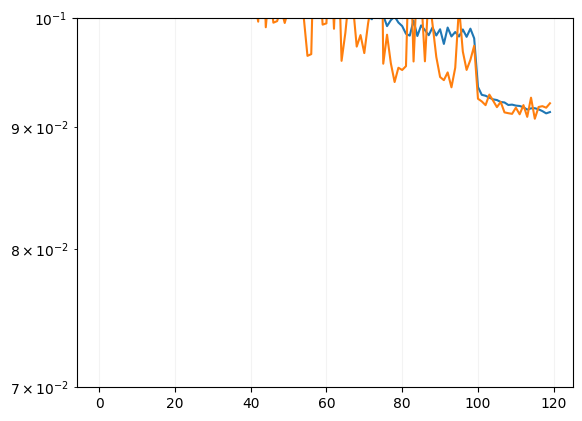

In [32]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.ylim(0.07, 0.1)
plt.yscale("log");
plt.grid(alpha=0.15)

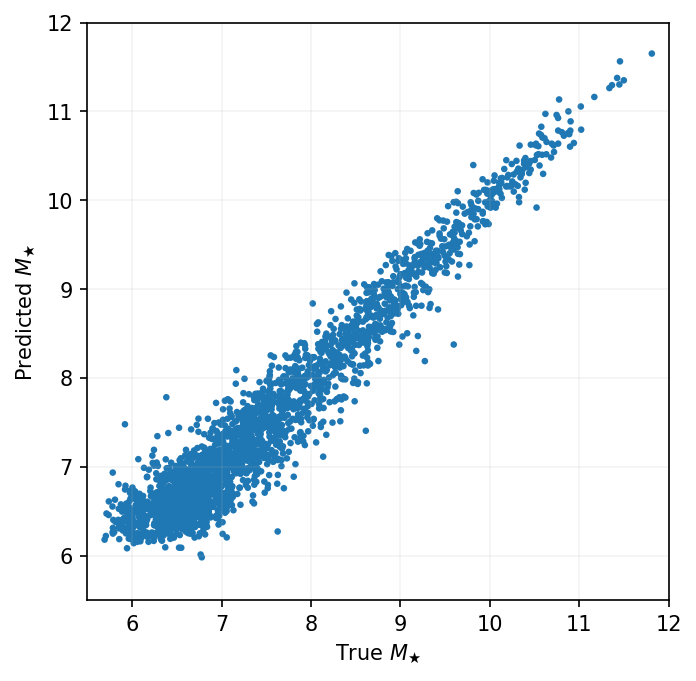

In [33]:
valid_loss, p, y  = validate(valid_loader, model, device=device)

plt.figure(figsize=(5,5), dpi=150)
plt.scatter(y, p, s=10, edgecolors="none", )
plt.xlabel(r"True $M_{\bigstar}$")
plt.ylabel(r"Predicted $M_{\bigstar}$")
plt.grid(alpha=0.15)
plt.xlim(5.5, 12)
plt.ylim(5.5, 12)
plt.show()

## make deeper

In [13]:
with open("merger_trees.pkl", "rb") as f:
    trees = pickle.load(f)

random.shuffle(trees)

batch_size = 128

train_loader = DataLoader(trees[:88888], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(trees[88888:], batch_size=batch_size, shuffle=False)

In [72]:
class MultiSAGENet(torch.nn.Module):
    """A multi-layer GNN built using SAGEConv layers.

    Makes full graph-level predictions (i.e. one for each merger tree)
    """
    def __init__(
        self, 
        n_in=4, 
        n_hidden=16, 
        n_out=1, 
        n_layers=4, 
        aggr=["max", "mean"]
    ):
        super(MultiSAGENet, self).__init__()

        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.n_layers = n_layers
        self.aggr = aggr

        sage_convs = [SAGEConv(self.n_in, self.n_hidden, aggr=self.aggr)]                
        sage_convs += [SAGEConv(self.n_hidden, self.n_hidden, aggr=self.aggr) for _ in range(self.n_layers - 1)]
        self.convs = nn.ModuleList(sage_convs)
        
        self.mlp = nn.Sequential(
            nn.Linear(self.n_hidden, 4 * self.n_hidden, bias=True),
            nn.SiLU(),
            nn.LayerNorm(4 * self.n_hidden),
            nn.Linear(4 * self.n_hidden, self.n_hidden, bias=True)
        )
        self.readout = nn.Sequential(
            nn.Linear(3 * self.n_hidden, 4 * self.n_hidden, bias=True),
            nn.SiLU(),
            nn.LayerNorm(4 * self.n_hidden),
            nn.Linear(4 * self.n_hidden, 2 * self.n_out, bias=True)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.silu(x)

        x = self.mlp(x)
 
        out = torch.cat([
            global_mean_pool(x, data.batch),
            global_max_pool(x, data.batch), 
            global_add_pool(x, data.batch)
        ], axis=1)
              
        return self.readout(out)

In [73]:
model = MultiSAGENet(n_in=4, n_hidden=16, n_layers=8, n_out=1).to(device)
model

MultiSAGENet(
  (convs): ModuleList(
    (0): SAGEConv(4, 16, aggr=['max', 'mean'])
    (1-7): 7 x SAGEConv(16, 16, aggr=['max', 'mean'])
  )
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): SiLU()
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=64, out_features=16, bias=True)
  )
  (readout): Sequential(
    (0): Linear(in_features=48, out_features=64, bias=True)
    (1): SiLU()
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [93]:
def train(dataloader, model, optimizer, device="cuda", augment_noise=True):
    """Train GNN model using Gaussian NLL loss."""
    model.train()

    loss_total = 0
    for data in (dataloader):
        if augment_noise: 
            # add random noise to halo mass and vmax
            data_node_features_scatter = 3e-4 * torch.randn_like(data.x[:, :2]) * torch.std(data.x[:, :2], dim=0)
            data.x[:, :2] += data_node_features_scatter
            assert not torch.isnan(data.x).any() 

        data.to(device)

        optimizer.zero_grad()
        y_pred, logvar_pred = model(data).chunk(2, dim=1)
        assert not torch.isnan(y_pred).any() and not torch.isnan(logvar_pred).any()

        y_pred = y_pred.view(-1, model.n_out)
        logvar_pred = logvar_pred.mean()
        loss = 0.5 * (F.mse_loss(y_pred.view(-1), data.y) / 10**logvar_pred + logvar_pred)

        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    return loss_total / len(dataloader)


def validate(dataloader, model, device="cuda"):
    model.eval()

    loss_total = 0

    y_preds = []
    y_trues = []
    subhalo_ids = []

    for data in (dataloader):
        with torch.no_grad():
            data.to(device)
            y_pred, logvar_pred = model(data).chunk(2, dim=1)
            y_pred = y_pred.view(-1, model.n_out)
            logvar_pred = logvar_pred.mean()
            loss = 0.5 * (F.mse_loss(y_pred.view(-1), data.y) / 10**logvar_pred + logvar_pred)

            loss_total += loss.item()
            y_preds += list(y_pred.detach().cpu().numpy())
            y_trues += list(data.y.detach().cpu().numpy())

    y_preds = np.concatenate(y_preds)
    y_trues = np.array(y_trues)
    subhalo_ids = np.array(subhalo_ids)

    return (
        loss_total / len(dataloader),
        y_preds,
        y_trues,
    )

In [94]:
train_losses = []
valid_losses = []

n_epochs = 100

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

print(f"Epoch    Train loss   Valid Loss      RSME ")
for epoch in range(n_epochs):

    train_loss = train(train_loader, model, optimizer, device=device)
    valid_loss, p, y  = validate(valid_loader, model, device=device)

    print(f" {epoch + 1: >4d}    {train_loss: >9.5f}    {valid_loss: >9.5f}    {np.sqrt(np.mean((p - y.flatten())**2)): >10.6f}")
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

Epoch    Train loss   Valid Loss      RSME 
    1     -0.04180     -0.05838      0.346515
    2     -0.09349     -0.12025      0.302201
    3     -0.10175     -0.13612      0.289885
    4     -0.10953     -0.10757      0.313359
    5     -0.10882     -0.13909      0.289086
    6     -0.11577     -0.11861      0.302825
    7     -0.11653     -0.14614      0.285180
    8     -0.12088     -0.14677      0.285123
    9     -0.12205     -0.13167      0.295126
   10     -0.12466     -0.15092      0.279834
   11     -0.12647     -0.15407      0.279310
   12     -0.12973     -0.15047      0.282243
   13     -0.12737     -0.14320      0.286881
   14     -0.13111     -0.13166      0.290918
   15     -0.13015     -0.14690      0.283434
   16     -0.13461     -0.15155      0.282296
   17     -0.13294     -0.14047      0.289149
   18     -0.13428     -0.06012      0.336165
   19     -0.13360     -0.14873      0.282219
   20     -0.13785     -0.16071      0.275284
   21     -0.12812     -0.15240     

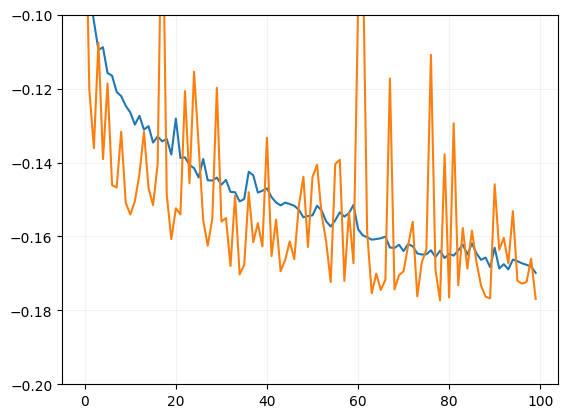

In [95]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.ylim(-0.2, -0.1)
plt.grid(alpha=0.15)

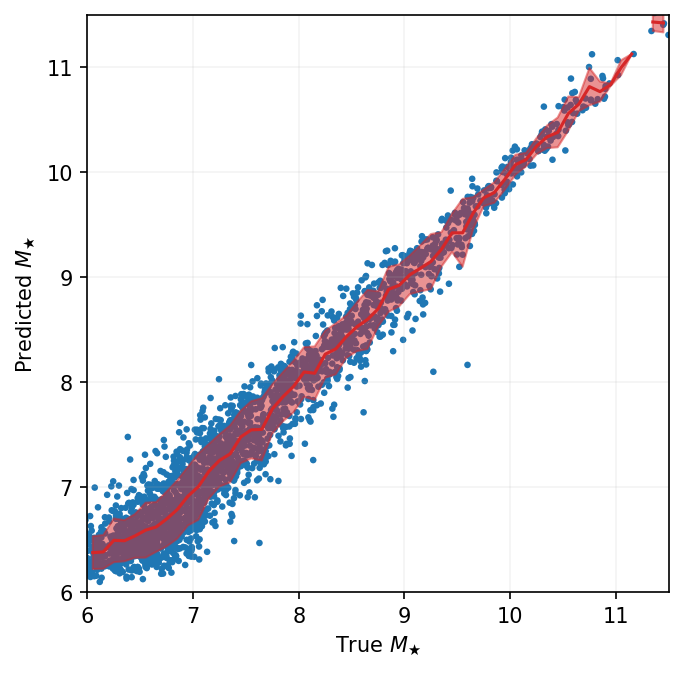

In [96]:
valid_loss, p, y  = validate(valid_loader, model, device=device)

bin_edges = np.arange(6., 12.5, 0.1)
means, *_ = binned_statistic(y, p, statistic="mean", bins=bin_edges)
stds, *_ = binned_statistic(y, p, statistic="std", bins=bin_edges)

plt.figure(figsize=(5,5), dpi=150)
plt.scatter(y, p, s=10, edgecolors="none", )
plt.plot(bin_edges[:-1]+0.05, means, c="C3")
plt.fill_between(bin_edges[:-1]+0.05, means-stds, means+stds, color="C3", alpha=0.5)
plt.xlabel(r"True $M_{\bigstar}$")
plt.ylabel(r"Predicted $M_{\bigstar}$")
plt.grid(alpha=0.15)
plt.xlim(6, 11.5)
plt.ylim(6, 11.5)
plt.show()

In [19]:
print(stds)

[0.14960855 0.12523084 0.1863098  0.17136131 0.17716102 0.22294693
 0.19827722 0.22832174 0.23803381 0.2447444  0.29472756 0.2544182
 0.25200188 0.23944175 0.25214417 0.28037693 0.33479747 0.26057192
 0.26870017 0.26214903 0.25319485 0.26163353 0.24334765 0.26233629
 0.22283774 0.23717838 0.31196855 0.16332549 0.22144815 0.22086387
 0.19502198 0.26664049 0.28736384 0.18356484 0.17687149 0.34157384
 0.13566595 0.06860929 0.11979564 0.113597   0.11679935 0.08284838
 0.08924417 0.12886312 0.19617573 0.15910145 0.07037987 0.19986403
 0.12635473 0.02479887 0.09977007 0.                nan 0.05011034
 0.10813106        nan        nan        nan 0.                nan
        nan        nan        nan        nan]


In [104]:
def compute_metrics(p, y):
    nmad = median_abs_deviation((p-y), scale="normal")    
    std = np.std(p - y)
    bias = np.mean(p - y)
    f_outlier = np.mean(np.absolute(p-y) > 3*nmad)

    return nmad, std, bias, f_outlier

In [108]:
nmad, std, bias, f_outlier = compute_metrics(p, y)

print(f"  NMAD scatter     = {nmad:.3f} dex")
print(f"  stdev scatter    = {std:.3f} dex")
print(f"  bias             = {bias:.3f} dex")
print(f"  outlier fraction = {100*f_outlier:.3f}%")

  NMAD scatter     = 0.243 dex
  stdev scatter    = 0.264 dex
  bias             = 0.022 dex
  outlier fraction = 1.018%
